In [1]:
import numpy as np
import bms_env
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random


from utils import *



# Import the necessary libraries
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env

In [2]:
# bms = bms_env.BMSenv(num_cells= 2, k_tanh_params= [0.75, 1.5], Q_cells = [2.35, 2.35])
bms = bms_env.BMSenv(num_cells= 5, k_tanh_params= [0.8, 2.5, 0.5, 1.5, 2], Q_cells = [2.35, 1., 0.5, 3, 1.75])
num_cells_ = 100

np.random.seed(0)
bms = bms_env.BMSenv(num_cells= num_cells_, 
                     k_tanh_params= np.random.uniform(0.75, 2.5, num_cells_), 
                     Q_cells = np.random.uniform(1, 5, num_cells_))

T = 30_000
print(bms)

BMSenv(num_cells=100,
        k_tanh_params=[1.71042363 2.00158139 1.80483591 1.70354557 1.4913959  1.8803147
 1.51577762 2.31060275 2.43640983 1.42102266 2.13551882 1.67556611
 1.74407798 2.36979412 0.8743131  0.90247627 0.7853822  2.20708473
 2.11177431 2.27252126 2.4625821  2.14852749 1.55758888 2.11592606
 0.95698025 1.86986179 1.00086825 2.4031706  1.66323456 1.47565839
 1.21297232 2.10490896 1.54826308 1.74475941 0.78288215 1.83086212
 1.82116751 1.82963449 2.40155914 1.94318552 1.37913883 1.51480592
 1.97085459 0.85539458 1.91684175 1.92361627 1.11816948 0.97562102
 1.30199961 1.38649385 1.74784435 1.51755265 2.47965422 0.92857842
 1.11553432 1.03229166 1.89293957 1.1932603  1.56604385 1.17774479
 1.02819677 0.9431565  1.89857678 0.99182016 1.09401913 1.39526905
 2.18673815 0.91992723 2.21640359 0.91817221 2.45880406 1.5701396
 2.4593319  1.80847966 2.04371126 0.81857864 1.24491218 0.96034398
 1.26824535 0.95777351 1.30647056 1.47496024 0.86225812 1.96182621
 1.74155254 1.214431

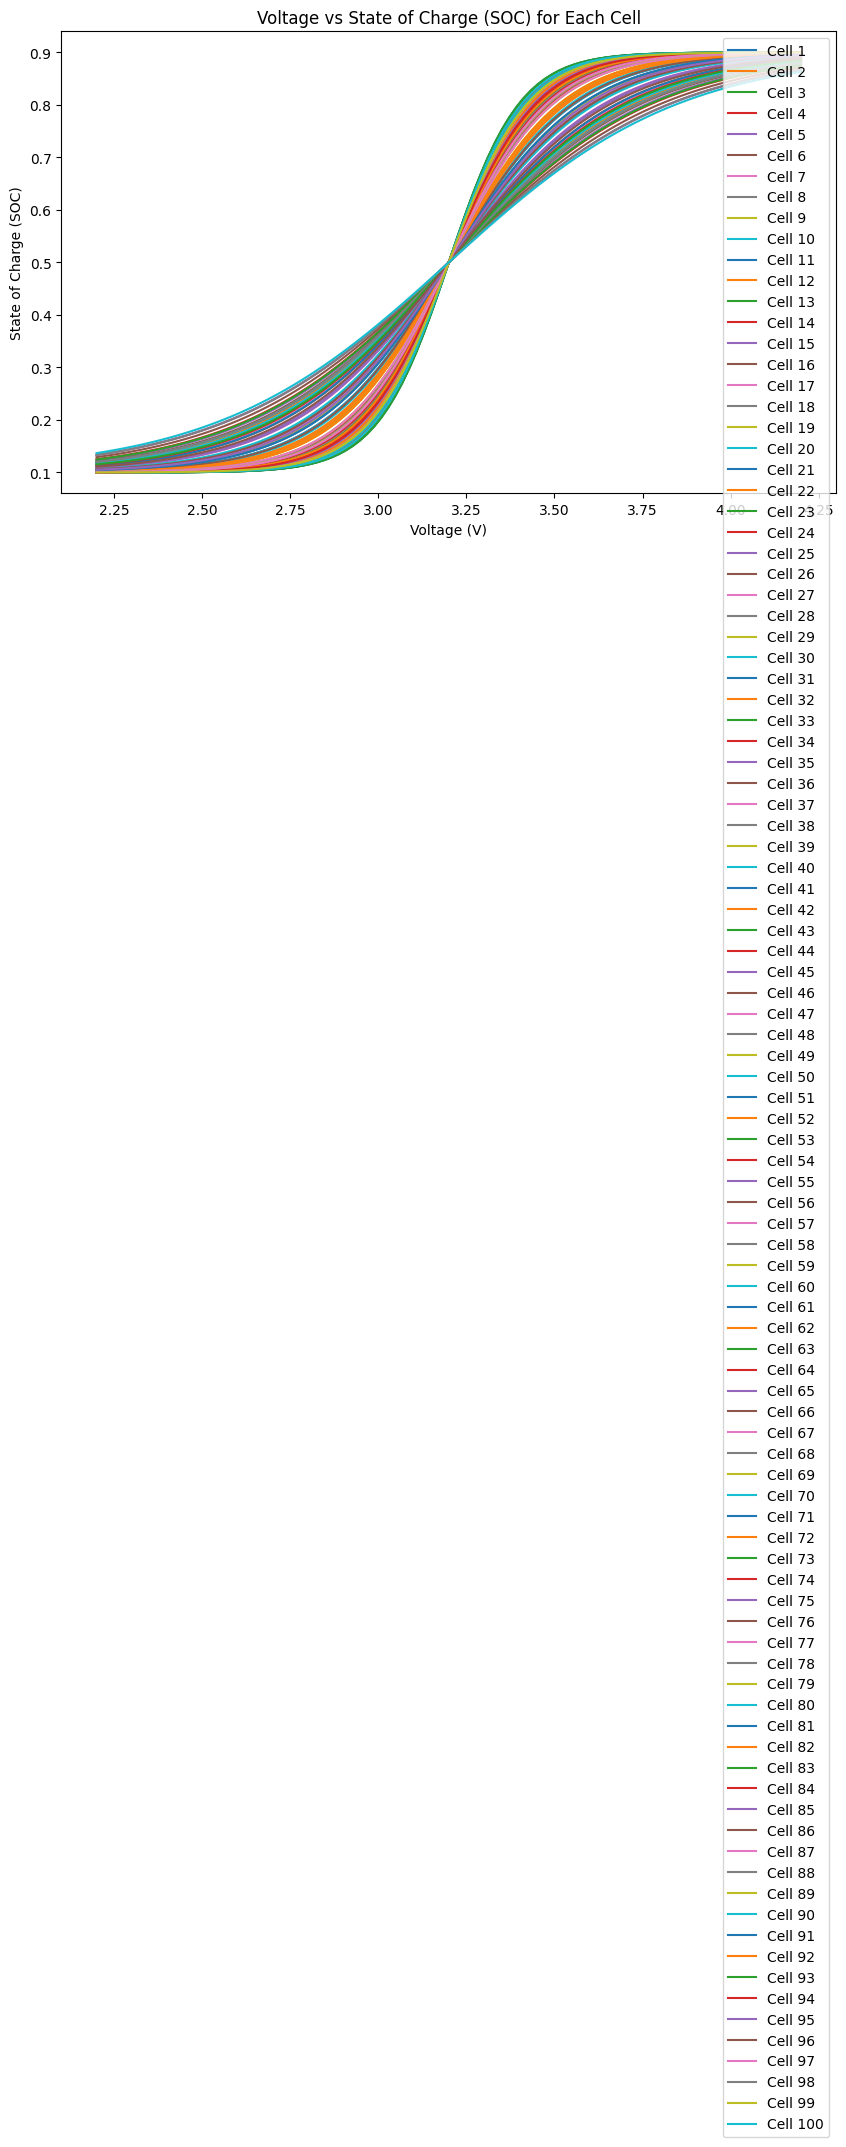

In [3]:
plot_voltage_vs_soc(bms)

# Random Controller

In [4]:
bms.reset()
states_5 = [bms.state]
states_soc_5 = [bms.state_soc]
actions_5 = []
rewards_5 = []
dones_5 = [False]
actions_int_5 = []

while not dones_5[-1] and len(states_5) < T:
    action = bms.action_space.sample()
    # while action == 0:
    #     action = bms.action_space.sample()
    actions_int_5.append(bms.switch_action_to_int_action(action))
    state, reward, done, _, _ = bms.step(action)
    states_5.append(state)
    states_soc_5.append(bms.state_soc)
    actions_5.append(action)
    rewards_5.append(reward)
    dones_5.append(done)

print(f"Sum of rewards: {np.sum(rewards_5)}")

Sum of rewards: -38.285850342874


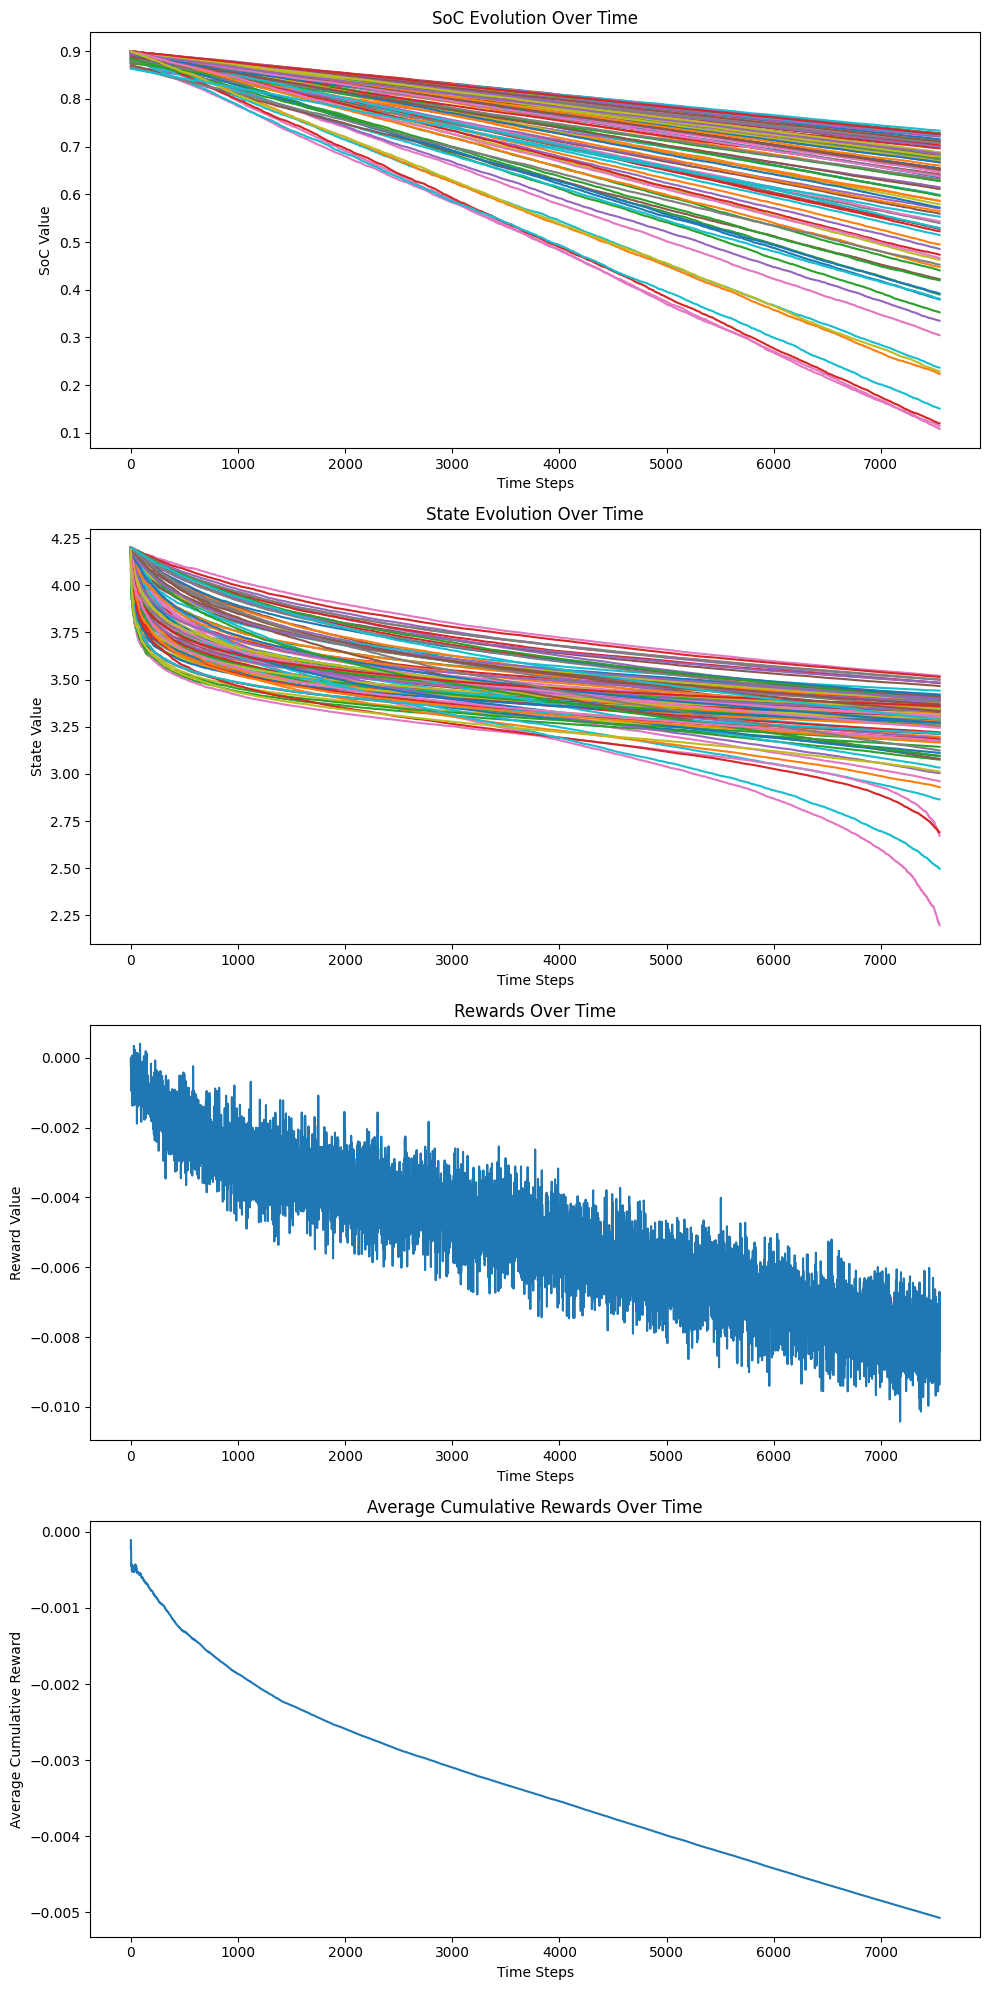

In [6]:
# Convert list of arrays to a 2D array for easier plotting
data_array_soc = np.array(states_soc_5)
data_array_states = np.array(states_5)
data_array_rewards = np.array(rewards_5)

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot states_soc_5
for feature_idx in range(bms.num_cells):
    axs[0].plot(range(len(data_array_soc)), data_array_soc[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('SoC Value')
axs[0].set_title('SoC Evolution Over Time')
# axs[0].legend()

# Plot states_5
for feature_idx in range(bms.num_cells):
    axs[1].plot(range(len(data_array_states)), data_array_states[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('State Value')
axs[1].set_title('State Evolution Over Time')
# axs[1].legend()

# Plot rewards_5
axs[2].plot(range(len(data_array_rewards)), data_array_rewards, label='Rewards')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Reward Value')
axs[2].set_title('Rewards Over Time')
# axs[2].legend()

# Plot average cumulative rewards
cumulative_rewards = np.cumsum(data_array_rewards)
average_cumulative_rewards = cumulative_rewards / (np.arange(len(cumulative_rewards)) + 1)
axs[3].plot(range(len(average_cumulative_rewards)), average_cumulative_rewards, label='Average Cumulative Rewards')
axs[3].set_xlabel('Time Steps')
axs[3].set_ylabel('Average Cumulative Reward')
axs[3].set_title('Average Cumulative Rewards Over Time')
# axs[3].legend()

plt.tight_layout()
plt.show()

In [17]:
plot_bms_evolution(bms, states_5, states_soc_5, actions_5, rewards_5, dones_5, include_bad_rewards=True)

KeyboardInterrupt: 

# TABULAR Q-Learning

In [7]:
# bins = np.array([2.2, 2.5, 2.8, 3, 3.15, 3.30 , 3.40, 3.50 , 3.65, 3.80, 4.0 ,4.2])
bins = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])



In [8]:
bins

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [9]:
print(bms.int_action_to_switch_action(0))
print(bms.int_action_to_switch_action(1))
print(bms.int_action_to_switch_action(2))
print(bms.int_action_to_switch_action(3))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]


# Efficient Tabular Q-Learning

In [10]:
# # Initialize the Q-table with a default value of 0.0 for each (state, action) pair
# init_Q_value = 0.0
# Q = defaultdict(lambda: init_Q_value)

In [11]:


# # Assuming bms, bins, T, and other relevant variables/functions are already defined

# num_episodes = 50

# for episode in range(num_episodes):

#     bms.reset()
#     states_6 = [bms.state]
#     states_soc_6 = [bms.state_soc]
#     actions_6 = []
#     rewards_6 = []
#     dones_6 = [False]
#     random_actions_6 = []
#     actions_int_6 = []
#     states_int_6 = [tuple(discretize_features(states_soc_6[-1], bins))]

#     epsilon = 1/(episode + 1)
#     stepsize = 0.5
#     gamma = 0.99

#     if episode  >= num_episodes - 1:
#         epsilon = 0.0

#     while not dones_6[-1] and len(states_soc_6) < T:

#         if len(dones_6) % 1000 == 0:
#             print('\n')
#             print(f"Episode: {episode + 1}")
#             print(f"Timesteps: {len(dones_6)}")
#             print(len(Q))

#         state_int = tuple(discretize_features(states_soc_6[-1], bins))

#         if np.random.uniform(0, 1) < epsilon:
#             random_actions_6.append(True)
#             action = bms.action_space.sample()
#         else:
#             random_actions_6.append(False)
#             # Collect all actions with non-zero Q-values for the current state
#             state_actions = [(s, a) for (s, a) in Q.keys() if s == state_int]

#             if state_actions:
#                 max_q_value = max(Q[(state_int, a)] for _, a in state_actions)
#                 max_actions = [a for _, a in state_actions if Q[(state_int, a)] == max_q_value]
#                 action_int = random.choice(max_actions)
#                 action = np.array(action_int)
#                 if max_q_value < init_Q_value:
#                     action = bms.action_space.sample()
#             else:
#                 action = bms.action_space.sample()

#         action_int = tuple(action)
#         actions_int_6.append(action_int)

#         state, reward, done, _, _ = bms.step(action)
#         state_soc = bms.state_soc
#         states_6.append(state)
#         states_soc_6.append(state_soc)
#         actions_6.append(action)
#         rewards_6.append(reward)
#         dones_6.append(done)

#         if not done:
#             next_state_int = tuple(discretize_features(state_soc, bins))
#             states_int_6.append(next_state_int)
#             next_state_actions = [(s, a) for (s, a) in Q.keys() if np.all(s == next_state_int)]
#             if next_state_actions:
#                 max_next_q_value = max(Q[(next_state_int, a)] for _, a in next_state_actions)
#             else:
#                 max_next_q_value = 0.0
            
#             if (state_int, action_int) not in Q:
#                 Q[(state_int, action_int)] = init_Q_value
                
#             Q[(state_int, action_int)] = Q[(state_int, action_int)] + stepsize * (
#                 reward + gamma * max_next_q_value - Q[(state_int, action_int)]
#             )

#         # # Remove entries with Q-values less than 0.0
#         Q = {k: v for k, v in Q.items() if v >= 0}
        


#     print(f"Sum of rewards: {np.sum(rewards_6)}")


In [12]:
from collections import defaultdict
import heapq

# Assuming bms, bins, T, and other relevant variables/functions are already defined


# Initialize the Q-table with a default value of 0.0 for each (state, action) pair
init_Q_value = 0.0
Q = defaultdict(list)

num_episodes = 10_000

for episode in range(num_episodes):

    bms.reset()
    states_6 = [bms.state]
    states_soc_6 = [bms.state_soc]
    actions_6 = []
    rewards_6 = []
    dones_6 = [False]
    random_actions_6 = []
    actions_int_6 = []
    states_int_6 = [tuple(discretize_features(states_soc_6[-1], bins))]

    epsilon = 1/(episode + 1)
    stepsize = 0.1
    gamma = 0.95

    if episode >= num_episodes - 2:
        epsilon = 0.0

    while not dones_6[-1] and len(states_soc_6) < T:

        if len(dones_6) % 1000 == 0:
            print('\n')
            print(f"Episode: {episode + 1}")
            print(f"Timesteps: {len(dones_6)}")
            print(len(Q))

        state_int = tuple(discretize_features(states_soc_6[-1], bins))

        if np.random.uniform(0, 1) < epsilon:
            random_actions_6.append(True)
            action = bms.action_space.sample()
        else:
            random_actions_6.append(False)
            # Collect all actions with non-zero Q-values for the current state
            state_actions = Q[state_int]

            if state_actions:
                max_q_value = max(state_actions, key=lambda x: x[1])[1]
                max_actions = [a for a, q in state_actions if q == max_q_value]
                action_int = random.choice(max_actions)                
                action = np.array(action_int)
                if max_q_value < init_Q_value:
                    action = bms.action_space.sample()
            else:
                action = bms.action_space.sample()

        action_int = tuple(action)
        actions_int_6.append(action_int)

        state, reward, done, _, _ = bms.step(action)
        state_soc = bms.state_soc
        states_6.append(state)
        states_soc_6.append(state_soc)
        actions_6.append(action)
        rewards_6.append(reward)
        dones_6.append(done)

        if not done:
            next_state_int = tuple(discretize_features(state_soc, bins))
            states_int_6.append(next_state_int)
            next_state_actions = Q[next_state_int]
            if next_state_actions:
                max_next_q_value = max(next_state_actions, key=lambda x: x[1])[1]
            else:
                max_next_q_value = 0.0

            # Update Q-value
            current_q_value = next((q for a, q in Q[state_int] if a == action_int), init_Q_value)
            new_q_value = current_q_value + stepsize * (reward + gamma * max_next_q_value - current_q_value)

            # Maintain only top 3 actions
            if len(Q[state_int]) < 100:
                heapq.heappush(Q[state_int], (action_int, new_q_value))
            else:
                heapq.heappushpop(Q[state_int], (action_int, new_q_value))

    print(f"Sum of rewards: {np.sum(rewards_6)}")



Episode: 1
Timesteps: 1000
5


Episode: 1
Timesteps: 2000
36


Episode: 1
Timesteps: 3000
75


Episode: 1
Timesteps: 4000
129


Episode: 1
Timesteps: 5000
169


Episode: 1
Timesteps: 6000
201


Episode: 1
Timesteps: 7000
252
Sum of rewards: -38.67846567294901


Episode: 2
Timesteps: 1000
275


Episode: 2
Timesteps: 2000
303


Episode: 2
Timesteps: 3000
342


Episode: 2
Timesteps: 4000
393


Episode: 2
Timesteps: 5000
434


Episode: 2
Timesteps: 6000
465


Episode: 2
Timesteps: 7000
513
Sum of rewards: -39.675318901528186


Episode: 3
Timesteps: 1000
539


Episode: 3
Timesteps: 2000
556


Episode: 3
Timesteps: 3000
592


Episode: 3
Timesteps: 4000
641


Episode: 3
Timesteps: 5000
676


Episode: 3
Timesteps: 6000
705


Episode: 3
Timesteps: 7000
752
Sum of rewards: -39.39899447216705


Episode: 4
Timesteps: 1000
768


Episode: 4
Timesteps: 2000
789


Episode: 4
Timesteps: 3000
824


Episode: 4
Timesteps: 4000
873


Episode: 4
Timesteps: 5000
906


Episode: 4
Timesteps: 6000
935


Episo

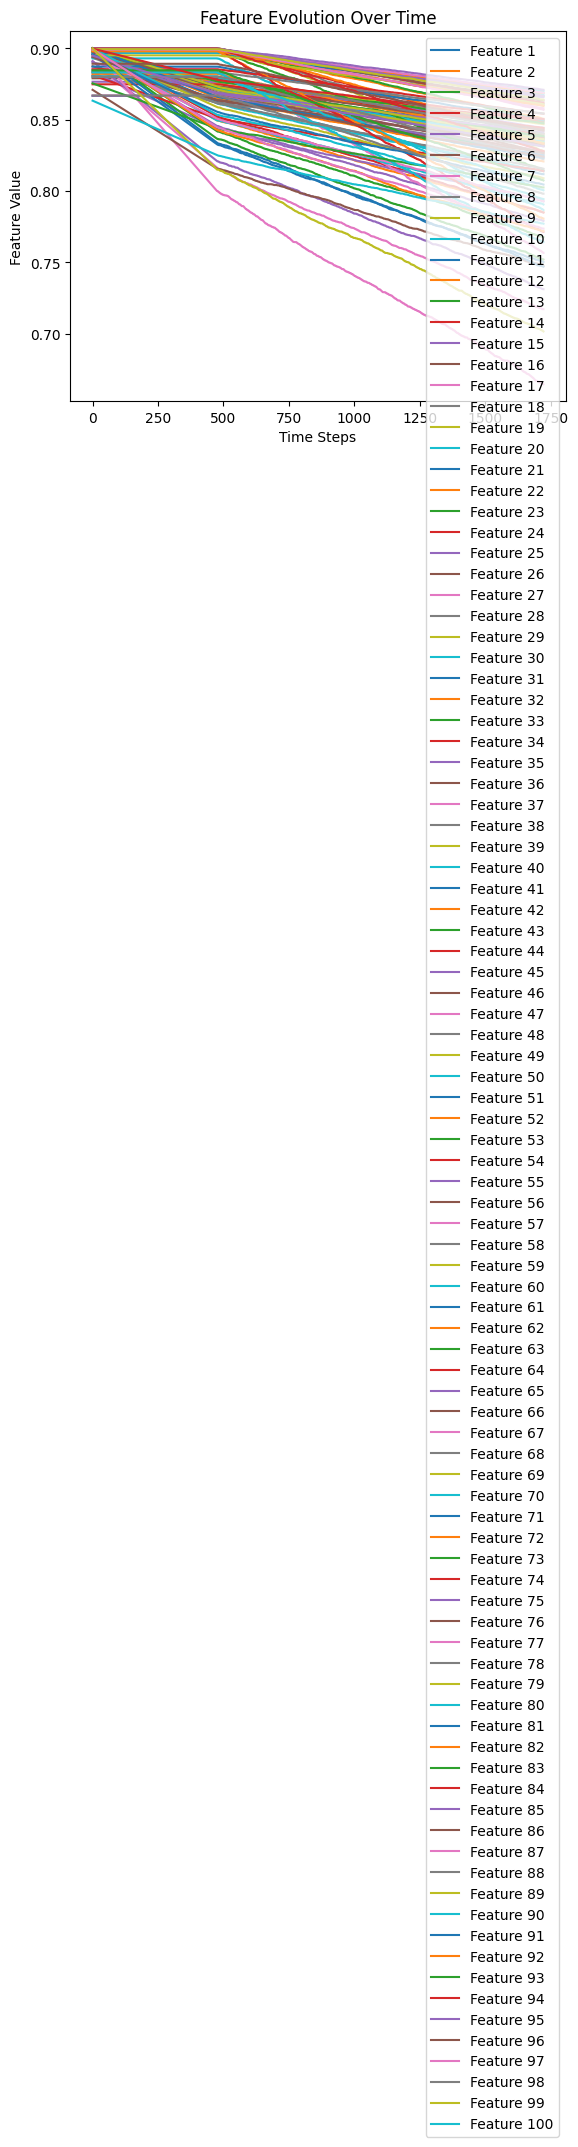

In [ ]:
# Convert list of arrays to a 2D array for easier plotting
data_array_soc = np.array(states_soc_6)
data_array_states = np.array(states_6)
data_array_rewards = np.array(rewards_6)

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot states_soc_5
for feature_idx in range(bms.num_cells):
    axs[0].plot(range(len(data_array_soc)), data_array_soc[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('SoC Value')
axs[0].set_title('SoC Evolution Over Time')
# axs[0].legend()

# Plot states_5
for feature_idx in range(bms.num_cells):
    axs[1].plot(range(len(data_array_states)), data_array_states[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('State Value')
axs[1].set_title('State Evolution Over Time')
# axs[1].legend()

# Plot rewards_5
axs[2].plot(range(len(data_array_rewards)), data_array_rewards, label='Rewards')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Reward Value')
axs[2].set_title('Rewards Over Time')
# axs[2].legend()

# Plot average cumulative rewards
cumulative_rewards = np.cumsum(data_array_rewards)
average_cumulative_rewards = cumulative_rewards / (np.arange(len(cumulative_rewards)) + 1)
axs[3].plot(range(len(average_cumulative_rewards)), average_cumulative_rewards, label='Average Cumulative Rewards')
axs[3].set_xlabel('Time Steps')
axs[3].set_ylabel('Average Cumulative Reward')
axs[3].set_title('Average Cumulative Rewards Over Time')
# axs[3].legend()

plt.tight_layout()
plt.show()

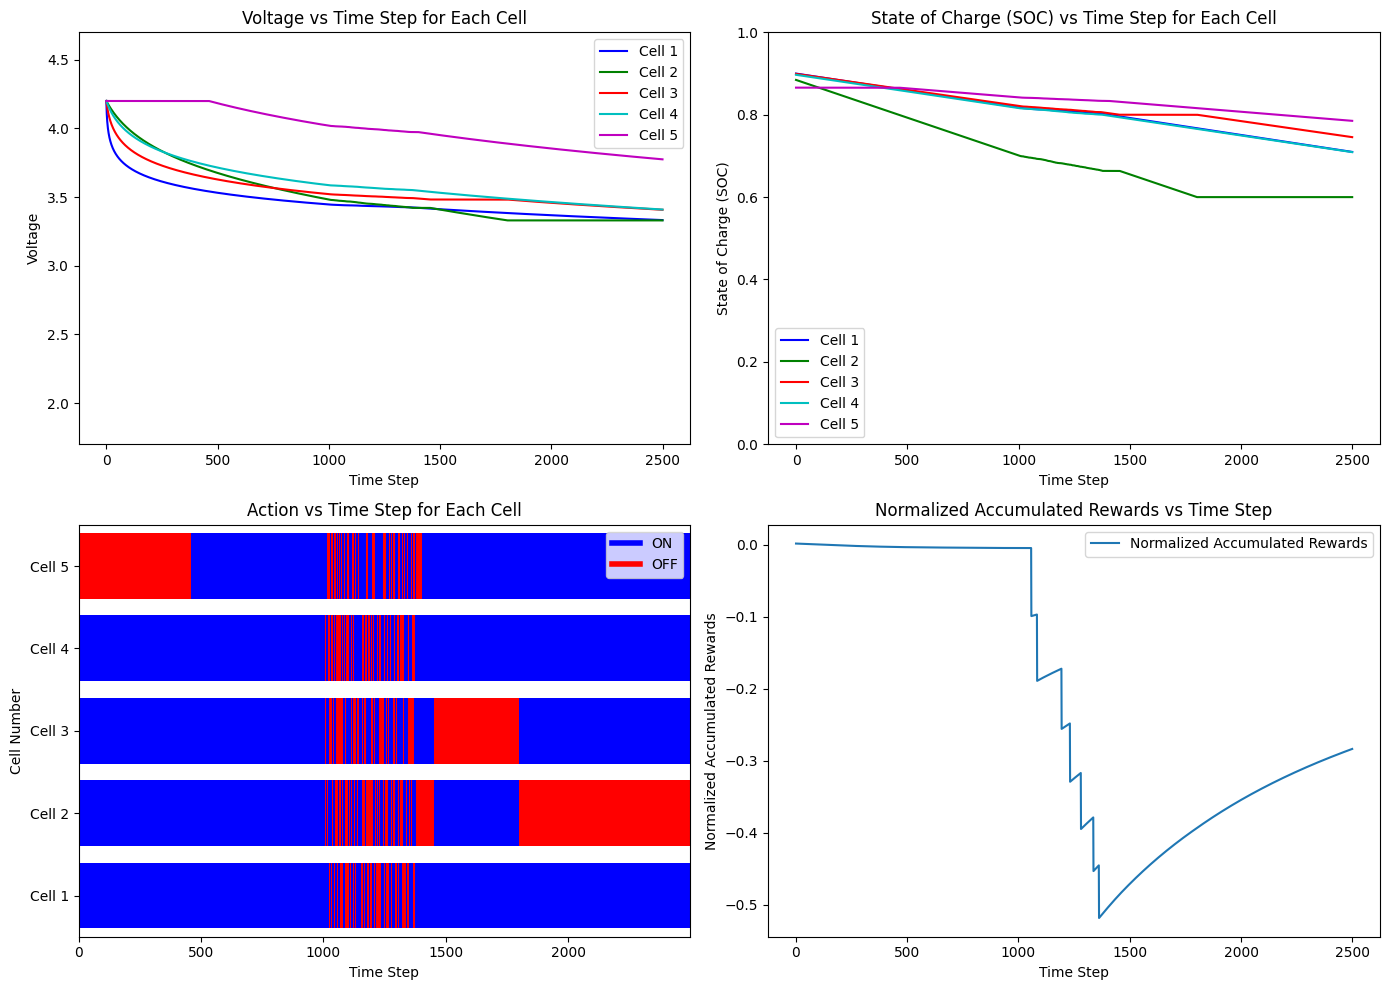

In [25]:
plot_bms_evolution(bms, states_6, states_soc_6, actions_6, rewards_6, dones_6, include_bad_rewards=True)

# PPO

In [ ]:
bms.reset()
# Check if the environment follows the gym interface
check_env(bms)

In [ ]:
model = PPO("MlpPolicy", bms,  verbose=1, gamma= 0.95)
model.learn(total_timesteps= 5_000_000)
model.save("ppo_bms")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2435 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.24e+03    |
|    ep_rew_mean          | -6.09       |
| time/                   |             |
|    fps                  | 1037        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015618853 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.3       |
|    explained_variance   | -5.34       |
|    learning_rate        | 0.0003      |
|    loss               

In [ ]:
model = PPO.load("ppo_bms")

bms.reset()
states_7 = [bms.state]
states_soc_7 = [bms.state_soc]
actions_7 = []
rewards_7 = []
dones_7 = [False]
random_actions_7 = []
actions_int_7 = []
states_int_7 = [tuple(discretize_features(states_soc_7[-1], bins))]

while not dones_7[-1] and len(states_7) <  T*10:
    action, _ = model.predict(bms.state, deterministic=False)
    actions_7.append(action)
    state_7, reward_7, done_7, _ , _= bms.step(action)
    states_7.append(state_7)
    states_soc_7.append(bms.state_soc)
    actions_int_7.append(tuple(action))
    rewards_7.append(reward_7)
    dones_7.append(done_7)

print(f"Sum of rewards: {np.sum(rewards_7)}")


Sum of rewards: -3.759476579261676


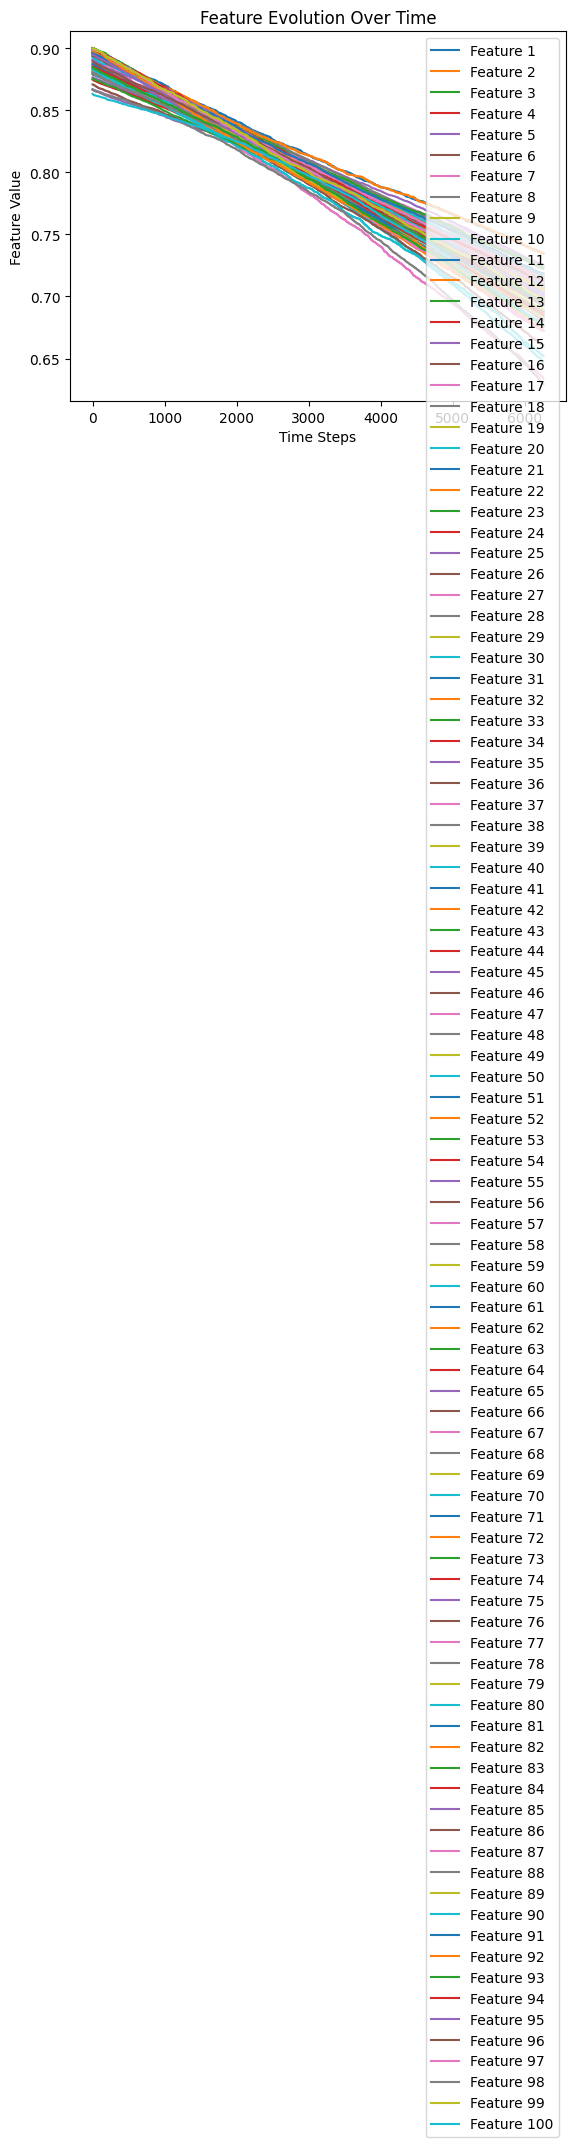

In [ ]:
# Convert list of arrays to a 2D array for easier plotting
data_array_soc = np.array(states_soc_7)
data_array_states = np.array(states_7)
data_array_rewards = np.array(rewards_7)

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot states_soc_5
for feature_idx in range(bms.num_cells):
    axs[0].plot(range(len(data_array_soc)), data_array_soc[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('SoC Value')
axs[0].set_title('SoC Evolution Over Time')
# axs[0].legend()

# Plot states_5
for feature_idx in range(bms.num_cells):
    axs[1].plot(range(len(data_array_states)), data_array_states[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('State Value')
axs[1].set_title('State Evolution Over Time')
# axs[1].legend()

# Plot rewards_5
axs[2].plot(range(len(data_array_rewards)), data_array_rewards, label='Rewards')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Reward Value')
axs[2].set_title('Rewards Over Time')
# axs[2].legend()

# Plot average cumulative rewards
cumulative_rewards = np.cumsum(data_array_rewards)
average_cumulative_rewards = cumulative_rewards / (np.arange(len(cumulative_rewards)) + 1)
axs[3].plot(range(len(average_cumulative_rewards)), average_cumulative_rewards, label='Average Cumulative Rewards')
axs[3].set_xlabel('Time Steps')
axs[3].set_ylabel('Average Cumulative Reward')
axs[3].set_title('Average Cumulative Rewards Over Time')
# axs[3].legend()

plt.tight_layout()
plt.show()

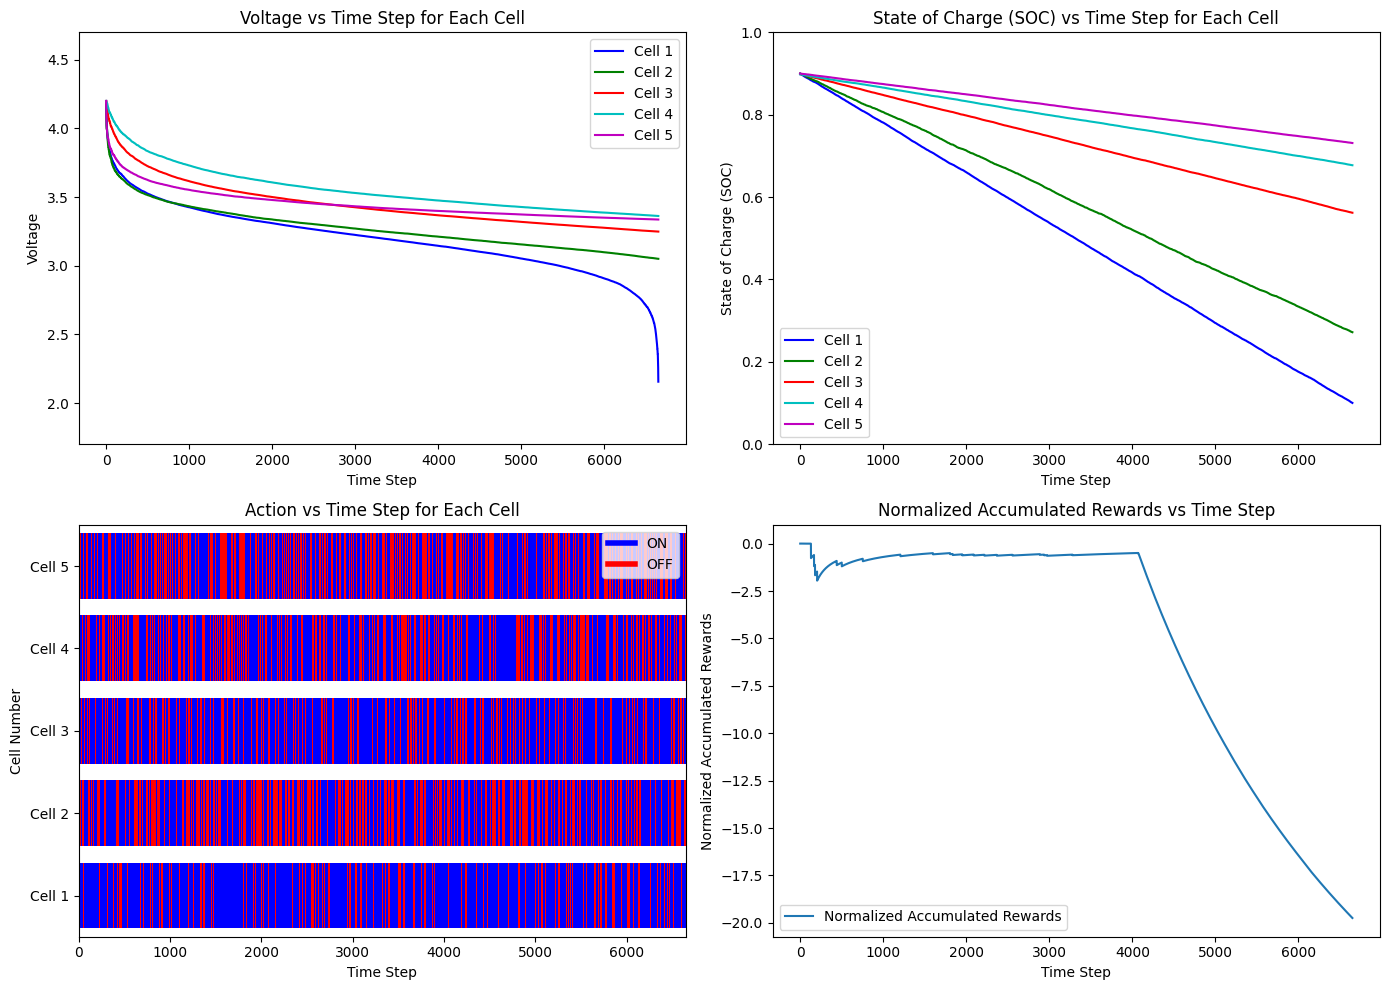

In [23]:
plot_bms_evolution(bms, states_7, states_soc_7, actions_7, rewards_7, dones_7, include_bad_rewards=True)

In [ ]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

def objective(trial):
    # Define the hyperparameters to tune
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-8, 1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
    n_steps = trial.suggest_int('n_steps', 16, 2048)
    gamma = trial.suggest_uniform('gamma', 0.5, 0.9999)
    
    # Create the environment
    bms.reset()
    
    # Create the model with the suggested hyperparameters
    model = PPO("MlpPolicy", bms, verbose=0, ent_coef=ent_coef, learning_rate=learning_rate, n_steps=n_steps, gamma=gamma)
    
    # Train the model
    model.learn(total_timesteps=10000)
    
    # Evaluate the model
    rewards = []
    for _ in range(10):
        bms.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(bms.state, deterministic=True)
            _, reward, done, _, _ = bms.step(action)
            total_reward += reward
        rewards.append(total_reward)
    
    # Return the mean reward
    return np.mean(rewards)

# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print(study.best_params)